In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Fetch and load data

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'
users_filename = 'BX-Users.csv'

--2022-10-24 16:25:19--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.1’

book-crossings.zip. 100%[===================>]  24.88M  45.9MB/s    in 0.5s    

2022-10-24 16:25:20 (45.9 MB/s) - ‘book-crossings.zip.1’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'}).dropna()

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

df_users = pd.read_csv(
    users_filename,
    encoding = "ISO-8859-1",
    sep=";")

# Analyzing the data

In [4]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271378 entries, 0 to 271378
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isbn    271378 non-null  object
 1   title   271378 non-null  object
 2   author  271378 non-null  object
dtypes: object(3)
memory usage: 8.3+ MB


In [5]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [6]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 17.5+ MB


In [7]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


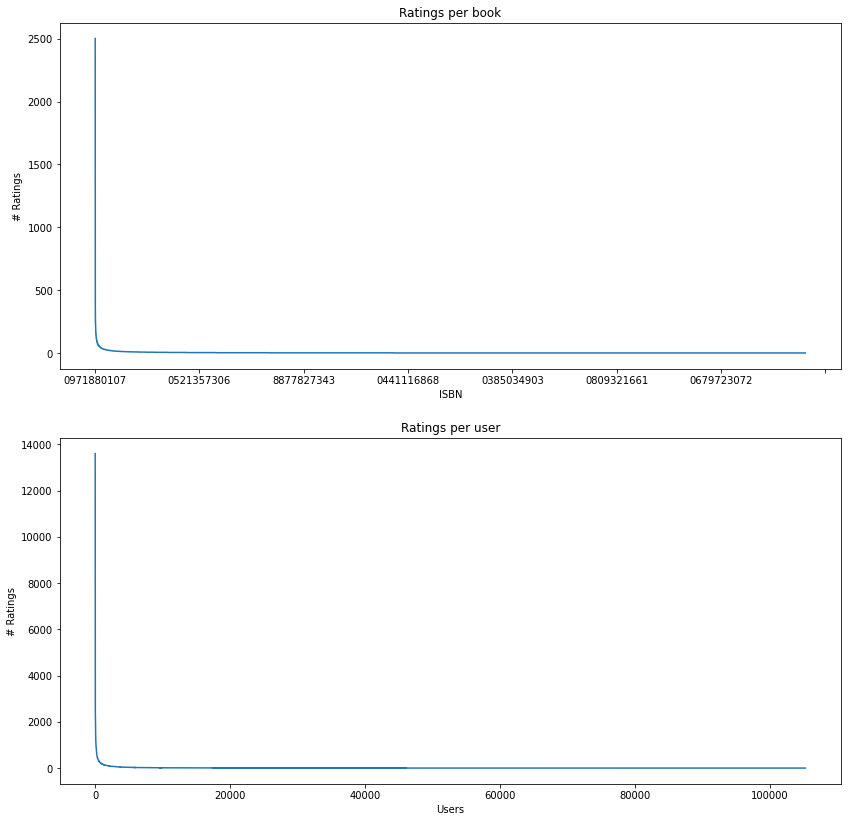

In [8]:
# plot rating frequences
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,14))
ax1.set_title("Ratings per book")
ax1.set_xlabel("ISBN")
ax1.set_ylabel("# Ratings")
df_ratings['isbn'].value_counts().sort_values(ascending=False).plot(ax=ax1)

ax2.set_title("Ratings per user")
ax2.set_xlabel("Users")
ax2.set_ylabel("# Ratings")
df_ratings['user'].value_counts().reset_index()['user'].sort_values(ascending=False).plot(ax=ax2)

# Removing books and users with very few ratings

In [9]:
# count rating per user and book
df_ratings['book_ratings_cnt'] = df_ratings.groupby('isbn')['isbn'].transform('count')
df_ratings['user_ratings_cnt'] = df_ratings.groupby('user')['user'].transform('count')
df_ratings.head()

,user,isbn,rating,book_ratings_cnt,user_ratings_cnt
0,276725,034545104X,0.0,60,1
1,276726,0155061224,5.0,2,1
2,276727,0446520802,0.0,116,1
3,276729,052165615X,3.0,1,2
4,276729,0521795028,6.0,1,2


In [10]:
# remove users with less than 200 ratings and movies with less than 100 ratings
df_ratings_cleaned = df_ratings.loc[(df_ratings['user_ratings_cnt'] >= 200) & (df_ratings['book_ratings_cnt'] >= 100)][['user', 'isbn', 'rating']]
df_ratings_cleaned

,user,isbn,rating
1456,277427,002542730X,10.0
1469,277427,0060930535,0.0
1471,277427,0060934417,0.0
1474,277427,0061009059,9.0
1484,277427,0140067477,0.0
...,...,...,...
1147304,275970,0804111359,0.0
1147436,275970,140003065X,0.0
1147439,275970,1400031346,0.0
1147440,275970,1400031354,0.0


# Create Sparse Matrix and pass data to KNN

In [11]:
# pivot ratings into book features and replace isbn with title
df_book_features = df_ratings_cleaned.pivot(
    index='isbn',
    columns='user',
    values='rating'
).fillna(0)

df_book_features.index = df_book_features.join(df_books.set_index('isbn'))['title']
df_book_features = df_book_features.sort_index()

df_book_features.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# convert dataframe to scipy sparse matrix and traing the model
mat_book_features = csr_matrix(df_book_features.values)

model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6, n_jobs=-1)
model.fit(mat_book_features)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=6)

In [13]:
# get point by title
title = 'The Queen of the Damned (Vampire Chronicles (Paperback))'
point = df_book_features.loc[title].values

In [14]:
# find 6 closest points (including self)
dists, idxs = model.kneighbors([point], n_neighbors=6)

books = df_book_features.iloc[idxs[0]].index.values
distances = dists[0]
ls = [[t, i] for t, i in zip(books, distances)][1:]
ls.sort(key=lambda x : x[1], reverse=True)
ls

[['Catch 22', 0.7939835],
 ['The Witching Hour (Lives of the Mayfair Witches)', 0.74486566],
 ['Interview with the Vampire', 0.73450685],
 ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384],
 ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.51784116]]

# Create recommender using KNN



In [15]:
# function to return recommended books - this will be tested
def get_recommends(book = "", num=6):
  # get point by title
  point = df_book_features.loc[book].values
  # find 6 closest points (including self)
  dists, idxs = model.kneighbors([point], n_neighbors=num)
  books = df_book_features.iloc[idxs[0]].index.values
  distances = dists[0]
  # prepare answer
  recommended_books = ([[t, i] for t, i in zip(books, distances)][1:])
  # sort the 5 closest books
  recommended_books.sort(key=lambda x : x[1], reverse=True)
  return [book, recommended_books]

In [16]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
